# Model 4

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import CategoricalFocalCrossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
import numpy as np

In [2]:
model_df = pd.read_csv("status.csv")
model_df.head()

,hypertension,heart_disease,diabetes,problematic,gender,smoking_history_No Info,smoking_history_current,smoking_history_not current,age,bmi,HbA1c_level,blood_glucose_level
0,0,1,0,0,0,0.0,0.0,1.0,1.000000,-0.645658,0.127273,-0.454545
1,0,0,0,0,0,1.0,0.0,0.0,0.349349,-0.595938,0.127273,-1.000000
2,0,0,0,0,1,0.0,0.0,1.0,-0.301301,-0.595938,-0.200000,-0.290909
3,0,0,0,0,0,0.0,1.0,0.0,-0.101101,-0.686275,-0.454545,-0.318182
4,1,1,0,0,1,0.0,1.0,0.0,0.899900,-0.763539,-0.527273,-0.318182


In [3]:
# Define features (X) and target (y)
X = model_df.drop("diabetes",axis=1)
y = model_df["diabetes"]

In [4]:
# the final test set is approximately 10% of the total data (train 90%, test 10%).
X_train_, X_test, y_train_, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)
X_train_.shape,X_test.shape

((89983, 11), (9999, 11))

In [5]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_, y_train_)
X_train.shape, X_test.shape

/Users/durudemirbag/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


((164666, 11), (9999, 11))

In [6]:
# Encode target variable using One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, drop=None)
y_train_encoded = encoder.fit_transform(y_train.to_frame())
y_test_encoded = encoder.transform(y_test.to_frame())
y_train_encoded, y_test_encoded

(array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]]),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]))

In [7]:
len(y_train_encoded), len(y_test_encoded),len(X_train), len(X_test)

(164666, 9999, 164666, 9999)

In [8]:
# Define focal loss
focal_loss = CategoricalFocalCrossentropy(
    gamma=2.0,    # focus parameter
    alpha=0.25,   # class weight
    from_logits=False   # softmax output
)

In [9]:
# Build a neural network model 
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(2, activation='softmax'))

# Compile the model with focal loss and Adam optimizer
model.compile(loss=focal_loss, optimizer=Adam(learning_rate=0.005), metrics=['accuracy','recall'])
model.summary()

# Train the model with early stopping to prevent overfitting
h = model.fit(
    X_train, y_train_encoded,
    epochs=200,
    batch_size=128,
    callbacks = EarlyStopping(
    monitor='val_loss',   
    patience=15),
    verbose=1,
    validation_data=(X_test, y_test_encoded) 
)

/Users/durudemirbag/miniforge3/envs/tf/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-24 23:33:51.720650: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-08-24 23:33:51.720767: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-08-24 23:33:51.720782: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-08-24 23:33:51.721135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-24 23:33:51.721171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:27

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,018 (398.51 KB)

 Trainable params: 102,018 (398.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


2025-08-24 23:33:52.793948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1287/1287 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.8819 - loss: 0.0168 - recall: 0.8819 - val_accuracy: 0.9056 - val_loss: 0.0123 - val_recall: 0.9056
Epoch 2/200
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 44s 34ms/step - accuracy: 0.8992 - loss: 0.0137 - recall: 0.8992 - val_accuracy: 0.9138 - val_loss: 0.0113 - val_recall: 0.9138
Epoch 3/200
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.9002 - loss: 0.0134 - recall: 0.9002 - val_accuracy: 0.9407 - val_loss: 0.0089 - val_recall: 0.9407
Epoch 4/200
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.9032 - loss: 0.0127 - recall: 0.9032 - val_accuracy: 0.8934 - val_loss: 0.0119 - val_recall: 0.8934
Epoch 5/200
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9067 - loss: 0.0122 - recall: 0.9067 - val_accuracy: 0.9161 - val_loss: 0.0105 - val_recall: 0.9161
Epoch 6/200
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.9076 - loss: 0.0120 - recall: 0.9076 - val_accuracy: 0.9159 - val_loss: 0.0106 - val_r

In [10]:
# Plot training vs validation accuracy and loss across epochs
def LossHistory (history):
    # Accuracy 
    plt.figure(figsize=(8,4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss 
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

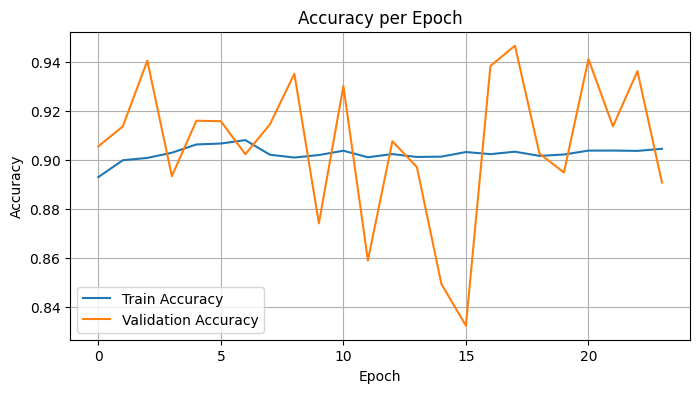

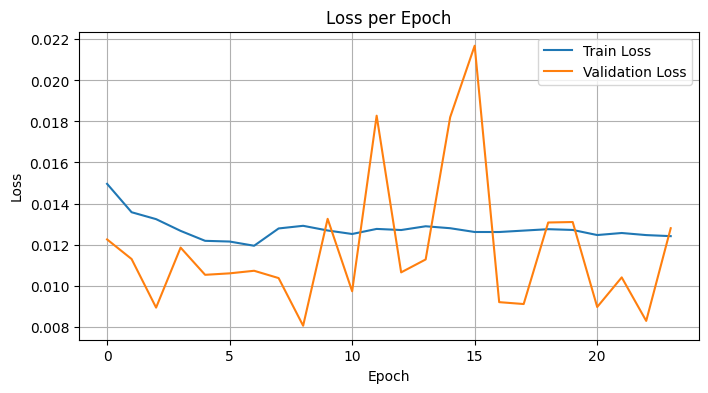

In [11]:
LossHistory(h)

In [12]:
# Evaluate model performance on train set
y_pred_prob_train = model.predict(X_train)
y_pred_train = np.argmax(y_pred_prob_train, axis=1)
y_true_train = np.argmax(y_train_encoded, axis=1)

print(classification_report(y_true_train, y_pred_train))

5146/5146 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     82333
           1       0.89      0.94      0.91     82333

    accuracy                           0.91    164666
   macro avg       0.91      0.91      0.91    164666
weighted avg       0.91      0.91      0.91    164666



In [13]:
# Evaluate model performance on test set
y_pred_prob_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_prob_test, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

print(classification_report(y_true, y_pred_test))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      9149
           1       0.43      0.93      0.59       850

    accuracy                           0.89      9999
   macro avg       0.71      0.91      0.76      9999
weighted avg       0.94      0.89      0.91      9999



In [14]:
# Generate confusion matrix to evaluate classification results
cm = confusion_matrix(y_true, y_pred_test)
cm

array([[8120, 1029],
       [  63,  787]])

In [15]:
# AUC calculation
# y_pred_prob[:,1] = predicted probability for class 1(diabetes)
auc = roc_auc_score(y_true, y_pred_prob_test[:, 1])
print("AUC score:", auc)

AUC score: 0.978122327737522


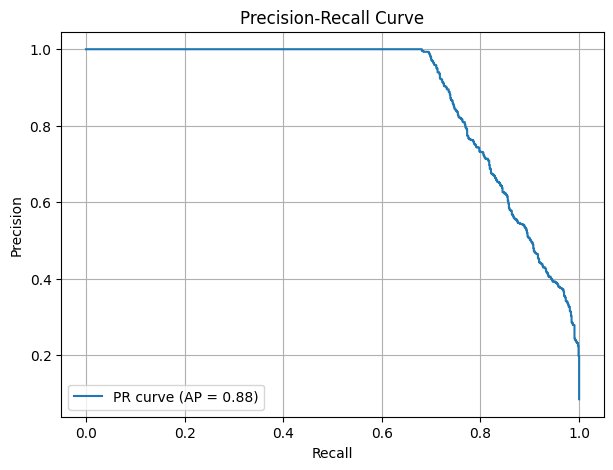

In [16]:
#Precision Recall Curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob_test[:, 1])

ap = average_precision_score(y_true, y_pred_prob_test[:, 1])

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f'PR curve (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [17]:
valid_idx = np.where(recall > 0.85)

precision_valid = precision[valid_idx]
recall_valid = recall[valid_idx]
thresholds_valid = thresholds[valid_idx[0]-1]  

best_idx = np.argmax(precision_valid)
best_precision = precision_valid[best_idx]
best_recall = recall_valid[best_idx]
best_threshold = thresholds_valid[best_idx]

print("Best Threshold:", best_threshold)

y_pred_opt = (y_pred_prob_test[:, 1] >= best_threshold).astype(int)


print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_true, y_pred_opt))

cm_opt = confusion_matrix(y_true, y_pred_opt)
print("Confusion Matrix (Optimized Threshold):\n", cm_opt)

Best Threshold: 0.6050067

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      9149
           1       0.62      0.85      0.72       850

    accuracy                           0.94      9999
   macro avg       0.80      0.90      0.84      9999
weighted avg       0.95      0.94      0.95      9999

Confusion Matrix (Optimized Threshold):
 [[8710  439]
 [ 126  724]]


In [18]:
valid_idx = np.where(recall > 0.90)

precision_valid = precision[valid_idx]
recall_valid = recall[valid_idx]
thresholds_valid = thresholds[valid_idx[0]-1]  

best_idx = np.argmax(precision_valid)
best_precision = precision_valid[best_idx]
best_recall = recall_valid[best_idx]
best_threshold = thresholds_valid[best_idx]

print("Best Threshold:", best_threshold)

y_pred_opt = (y_pred_prob_test[:, 1] >= best_threshold).astype(int)


print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_true, y_pred_opt))

cm_opt = confusion_matrix(y_true, y_pred_opt)
print("Confusion Matrix (Optimized Threshold):\n", cm_opt)

Best Threshold: 0.5443241

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      9149
           1       0.50      0.90      0.64       850

    accuracy                           0.92      9999
   macro avg       0.75      0.91      0.80      9999
weighted avg       0.95      0.92      0.93      9999

Confusion Matrix (Optimized Threshold):
 [[8387  762]
 [  83  767]]
